# Data pre-processing for EEG seizure detection

## Loading the dataset
The dataset is made available as multiple SMRX files generated by Spike2 analysis software. `neo` package can be used to read the data. 
There are 6 labelled seizures in the dataset for the target patient (mouse AJ, as described in the paper). The timestamps and associated filenames of each of the seizures is stored in a `list` of `dict`s, and can be loaded from the `seizures` module, as shown.

In [1]:
import neo
import numpy as np
import scipy as sp
import random

def generate_dataset(seizures, signal_length, sampling_rate):
    '''
    Generates the learning dataset by combining the labelled seizures (with padding)
    to create a balanced dataset. Returns the learning set and corresponding labels.
    '''
    
    data = np.empty((signal_length * sampling_rate, 15))
    labels = np.zeros(signal_length * sampling_rate)
    sample_start = 0
    
    random.shuffle(seizures)
    
    for seizure in seizures:
        reader = neo.io.CedIO(filename='data/' + seizure['filename'] + '.smrx')
        segment = reader.read_segment(time_slice=None, lazy=True) # lazy loading to save memory
        signals = segment.analogsignals
        
        seq_start = seizure['padded_sequence'][0]
        seq_end = seizure['padded_sequence'][1]
        
        for timestep in range(seq_start, seq_end - 1):
            
            sample_end = sample_start + sampling_rate
            
            for channel, signal in enumerate(signals):
                signal_slice = signal.load(time_slice=(timestep, timestep + 1))
                signal_slice = sp.signal.resample(signal_slice, sampling_rate)
                
                sample = sample_start
                for slice_index in range(sampling_rate):
                    data[sample, channel] = signal_slice[slice_index]
                    sample += 1
                    
            # generating labels
            if timestep >= seizure['sequence'][0] and timestep + 1 <= seizure['sequence'][1]:
                labels[sample_start:sample_end] = 1
                    
            sample_start = sample_end

    return data, labels

In [9]:
# loading data and generating the learning set
from seizures import seizures

sampling_rate = 3000
raw_data, labels = generate_dataset(seizures, 495, sampling_rate) # 495s is the total length of seizures + padding

# verifying the shape of the data
print(raw_data.shape)
print(labels.shape)

(1485000, 15)
(1485000,)


In [3]:
# verifying the class distribution
from collections import Counter
print("Class distribution: %s" % Counter(labels))

Class distribution: Counter({0.0: 747000, 1.0: 738000})


## Feature selection

Feature 0: 8632.672850
Feature 1: 988.212052
Feature 2: 18331.676305
Feature 3: 370.521057
Feature 4: 360.785689
Feature 5: 13187.539213
Feature 6: 544.775804
Feature 7: 40906.637158
Feature 8: 436.771780
Feature 9: 2.264460
Feature 10: 68843.886737
Feature 11: 255.015270
Feature 12: 120.855390
Feature 13: 705.893349
Feature 14: 1.773072


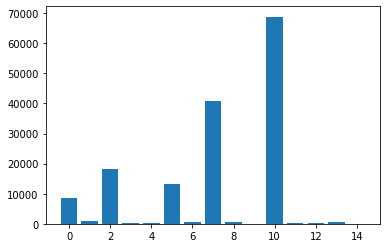

In [10]:
# performing the ANOVA F-test to compute feature relevance
from sklearn.feature_selection import SelectKBest, f_classif
from matplotlib import pyplot as plt

fs = SelectKBest(score_func=f_classif, k='all')
fs.fit(raw_data, labels)

# print the score for each feature
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
    
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

We see that 5/15 features have comparatively high relevance scores. In order to preserve any unknown correlations in the data, it could be useful to not drop most of the features, which will be the case if we choose k=5. Therefore, ~1/2 features will be preserved, with k=8.

In [12]:
from sklearn.model_selection import train_test_split

def train_val_test_split(data, labels):
    '''
    Splits data and labels into ~ 80:10:10 split.
    Returns tuples for the split data and labels
    '''
    train_data, x_test, train_labels, y_test = train_test_split(data, labels, test_size=0.1, shuffle=False)
    x_train, x_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.11, shuffle=False)
    y_train = np.asarray(y_train).astype('float32')
    y_val = np.asarray(y_val).astype('float32')
    y_test = np.asarray(y_test).astype('float32')
    
    return (x_train, x_val, x_test), (y_train, y_val, y_test)

In [13]:
# splitting the dataset into training, validation and test sets
X, Y = train_val_test_split(raw_data, labels)
x_train, x_val, x_test = X
y_train, y_val, y_test = Y

In [14]:
# select 8 most relevant features from the data
features = 8
fs = SelectKBest(score_func=f_classif, k=features)
fs.fit(raw_data, labels)

x_train = fs.transform(x_train)
x_val = fs.transform(x_val)
x_test = fs.transform(x_test)

## Baseline classifier
We will design an LSTM model and train it on the raw data, and will use it's performance as a baseline to evaluate the effectiveness of the various pre-processing methods explored. The hyperparameters for the model were experimentally selected, details of which can be found in the paper.

In [15]:
import tensorflow as tf
import keras
from keras.layers import LSTM, Dropout, Dense

def make_LSTM_classifier(x_train, y_train, x_val, y_val, verbose=0):
    '''
    Defines and trains an LSTM model.
    Returns the trained model instance.
    '''
    # defining the model
    model = keras.Sequential()
    model.add(LSTM(32, return_sequences=True, input_shape = (1, features)))
    model.add(Dropout(0.25))
    model.add(LSTM(32))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", 
                  metrics=[keras.metrics.binary_accuracy],
                  optimizer="sgd")
    
    # training the model
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=64, epochs=10, verbose=verbose, callbacks=[callback])
    
    return model

In [16]:
def generate_data_sequence(data, sequence_length, step):
    '''
    Reshapes the input data into a compatible shape for LSTM.
    '''
    sequence = []
    for start in range(0, len(data), step):
        end = start + sequence_length
        sequence.append(data[start:end])

    return np.array(sequence)

In [17]:
# transforming the data to comply with LSTM input shape
sequence_length = 1
step = 1

x_train_seq = generate_data_sequence(x_train, sequence_length, step)
x_val_seq = generate_data_sequence(x_val, sequence_length, step)
x_test_seq = generate_data_sequence(x_test, sequence_length, step)
print(x_train_seq.shape)
print(x_val_seq.shape)
print(x_test_seq.shape)

(1189485, 1, 8)
(147015, 1, 8)
(148500, 1, 8)


In [24]:
def perform_classification(x_train, y_train, x_val, y_val, x_test, y_test, runs=5):
    '''
    Performs classification using the tuned LSTM model.
    Returns the average accuracy percentage of the runs.
    '''
    accuracies = []
    
    print("=" * 50)
    for run in range(runs):
        print("Run #{:n}".format(run + 1))
        print("Training model...", end='')
        model = make_LSTM_classifier(x_train, y_train, x_val, y_val)
        print("Done")
        print("Evaluating model...", end='')
        results = model.evaluate(x_test, y_test, verbose=0)
        print("Done")
        accuracy = results[1] * 100
        print("Test Accuracy: {:n}%".format(round(accuracy, 2)))
        accuracies.append(accuracy)
        if run < (runs - 1):
            print("-" * 50)
    print("=" * 50)
    print("AVERAGE ACCURACY: {:n}%".format(round(sum(accuracies) / runs, 2)))
    print("=" * 50)

In [27]:
# performing the classification over raw normalized data
perform_classification(x_train_seq, y_train, x_val_seq, y_val, x_test_seq, y_test)

Run #1
Training model...Done
Evaluating model...Done
Test Accuracy: 70.96%
--------------------------------------------------
Run #2
Training model...Done
Evaluating model...Done
Test Accuracy: 85.05%
--------------------------------------------------
Run #3
Training model...Done
Evaluating model...Done
Test Accuracy: 71.95%
--------------------------------------------------
Run #4
Training model...Done
Evaluating model...Done
Test Accuracy: 73.14%
--------------------------------------------------
Run #5
Training model...Done
Evaluating model...Done
Test Accuracy: 69.6%
AVERAGE ACCURACY: 74.14%


We observe that our model does not generalize very well and therefore only has decent performance over nearly raw data. We will now proceed to see the effects of various pre-processing methodologies on the model performance. 

## Pre-processing
### Line-noise Filtering
A common pre-processing method used for EEG signals is to filter out electric line noise (50 Hz in Europe). We will begin by applying the Fourier transform on the signal to convert it to frequency-domain and applying a notch filter on the transformed signal from channel 6.

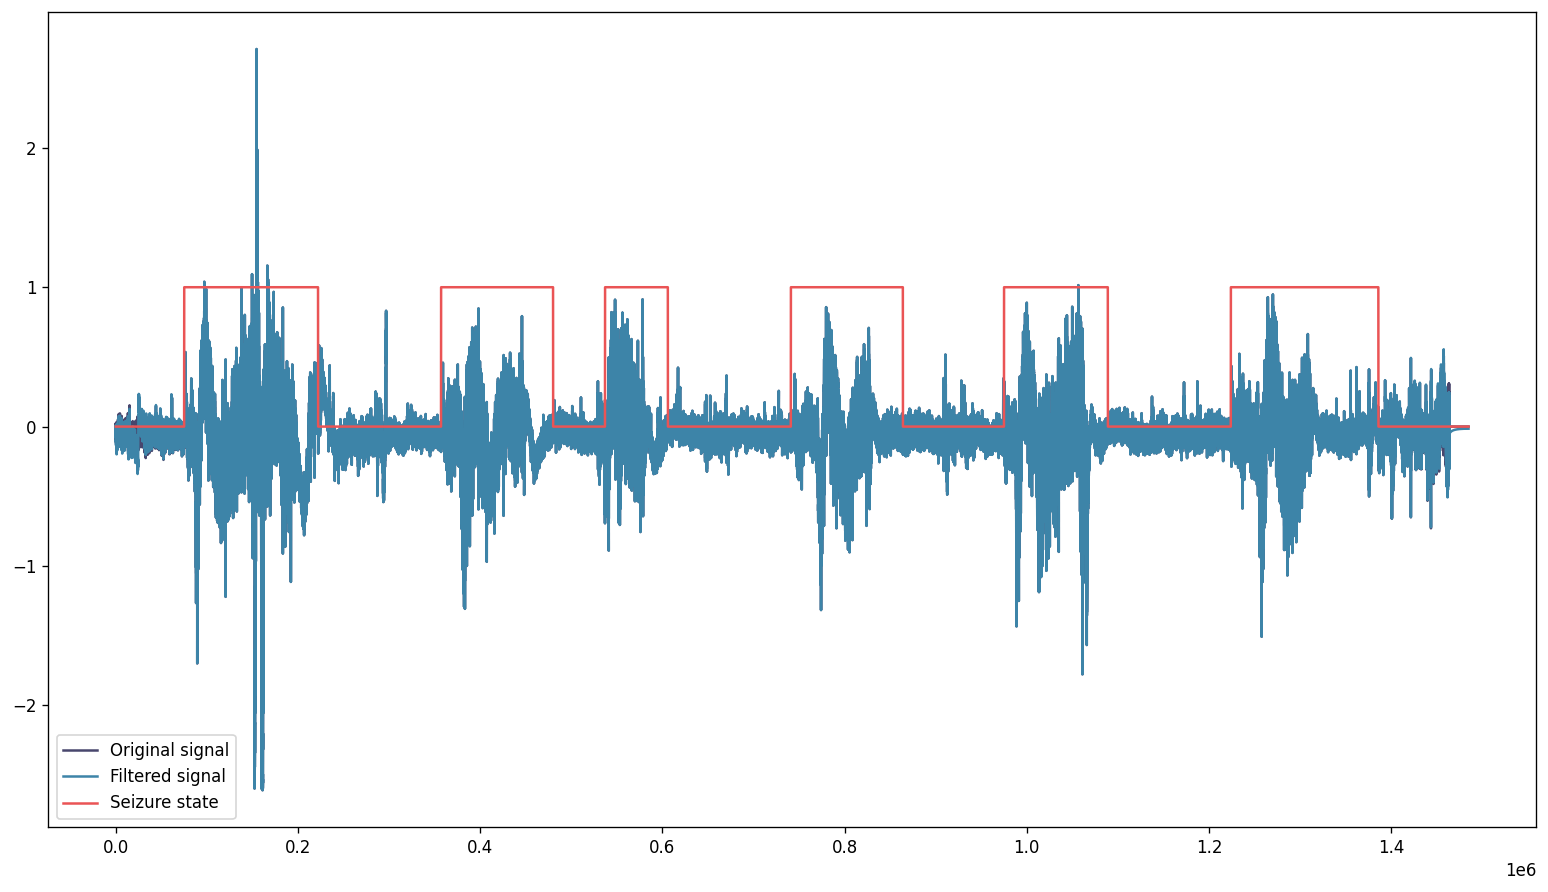

In [20]:
from scipy.fft import fft, fftfreq, ifft
from scipy.signal import iirnotch, filtfilt
from matplotlib import pyplot as plt

data = raw_data
signal = data[:, 6] # select channel 1 from the signal

yf = fft(signal)
xf = fftfreq(signal.shape[0], 1 / 3000)

sampling_rate = 3000 # Hz
noise = 50 # frequency to filter
w0 = noise / (sampling_rate / 2)
Q = 30
b, a = iirnotch(w0, Q)
filtered_signal = filtfilt(b, a, yf)

inverse_filtered_signal = ifft(filtered_signal)

fig = plt.figure(figsize=(16, 9), dpi=120)
plt.plot(signal, c='#48466D', label='Original signal')
plt.plot(inverse_filtered_signal, c='#3D84A8', label='Filtered signal')
plt.plot(labels, c='#EA5455', label="Seizure state")
plt.legend(loc="lower left")
plt.show()

It can be observed that the noise components have been dropped from the signal. We will proceed to apply the transformation to the entire dataset.

In [21]:
def remove_line_noise(data):
    # cast data to complex dtype to preserve the imaginary parts
    data = np.asarray(data, dtype=complex)
    for channel in range(features):
        signal_fft = fft(data[:, channel])
        fsignal = filtfilt(b, a, signal_fft)
        fsignal = ifft(fsignal)
        data[:, channel] = np.asarray(fsignal, dtype='complex_')
    
    return data

In [28]:
# applying the filter to every channel in the data
data = raw_data
data = fs.transform(data)
data = remove_line_noise(data)

In [29]:
# splitting the filtered dataset into training, validation and test sets
X, Y = train_val_test_split(data, labels)
x_train, x_val, x_test = X
y_train, y_val, y_test = Y

In [30]:
# generating data sequences for classification
x_train_seq = generate_data_sequence(x_train, sequence_length, step)
x_val_seq = generate_data_sequence(x_val, sequence_length, step)
x_test_seq = generate_data_sequence(x_test, sequence_length, step)
print(x_train_seq.shape)
print(x_val_seq.shape)
print(x_test_seq.shape)

(1189485, 1, 5)
(147015, 1, 5)
(148500, 1, 5)


In [31]:
# evaluating classification performance after removing line noise from the data
perform_classification(x_train_seq, y_train, x_val_seq, y_val, x_test_seq, y_test)

Run #1
Training model...Done
Evaluating model...Done
Test Accuracy: 72.55%
--------------------------------------------------
Run #2
Training model...Done
Evaluating model...Done
Test Accuracy: 72.61%
--------------------------------------------------
Run #3
Training model...Done
Evaluating model...Done
Test Accuracy: 71.66%
--------------------------------------------------
Run #4
Training model...Done
Evaluating model...Done
Test Accuracy: 86.56%
--------------------------------------------------
Run #5
Training model...Done
Evaluating model...Done
Test Accuracy: 71.82%
AVERAGE ACCURACY: 75.04%


We observe a slight increase in performance from removing the line noise from the channels. The low gain in performance is expected, given the data the low amount of noise or data that was removed.

### Moving average
Moving average or Rolling average is a statistical calculation used to smooth out fluctuations in time-series data and to highlight long-term variations. Elements of the moving average is calculated by finding the mean of all elements in a defined window. The next element of the moving average is calculated by shifting the window by a predefined step, and so on. The larger the window, the smoother the signal will be. It works essentially like a low-pass filter. We will apply it to channel 1 to visualize the transformation.

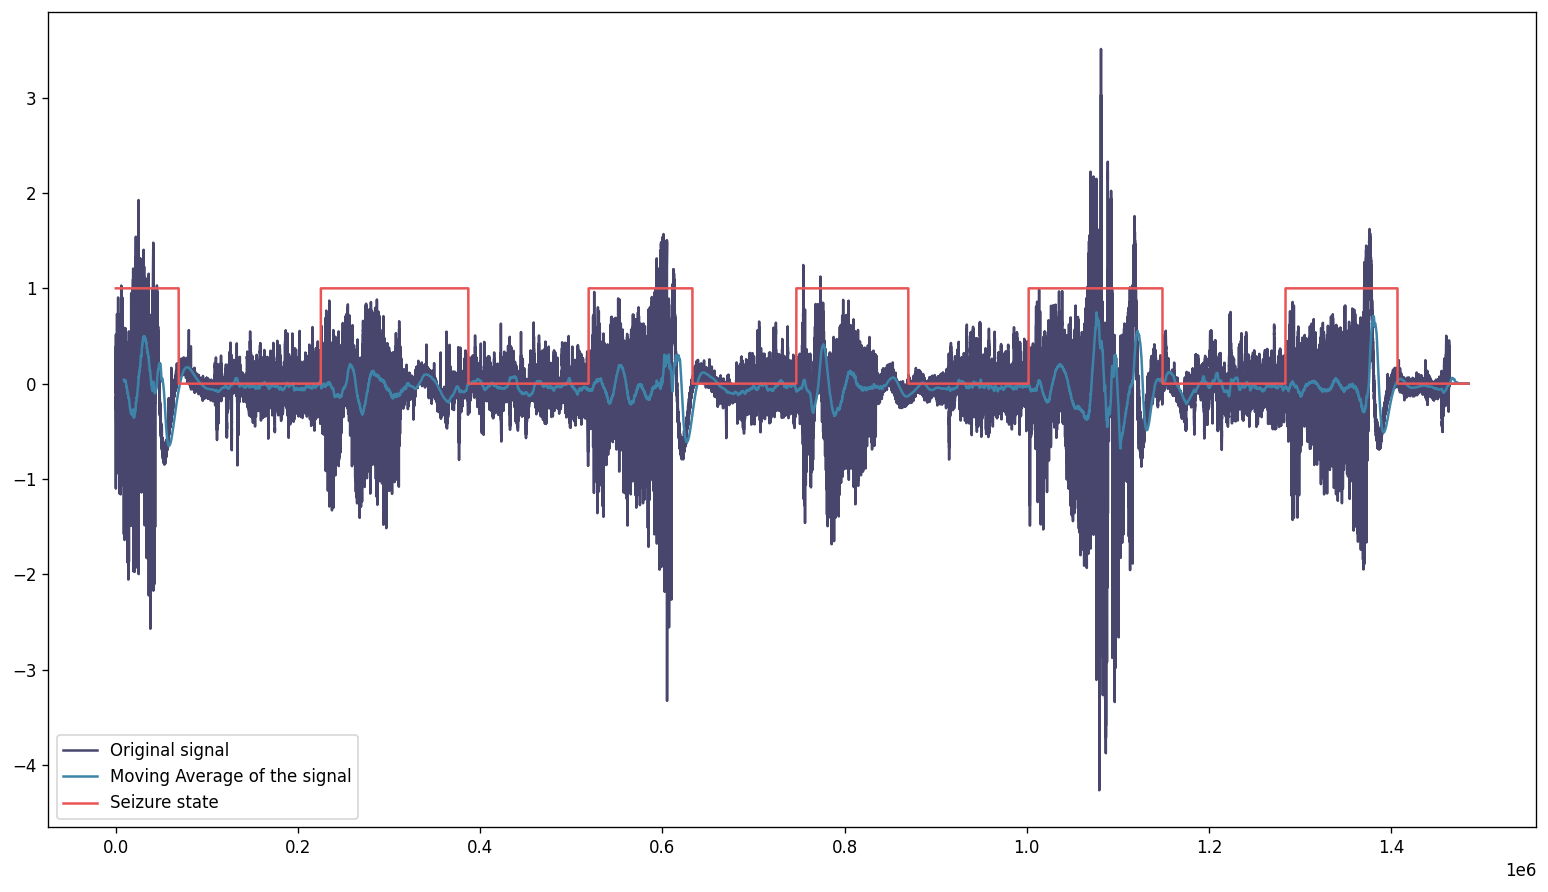

In [18]:
import pandas as pd

data = raw_data
signal = pd.Series(data[:, 1])
ma_signal = signal.rolling(window=3*3000).mean()

fig = plt.figure(figsize=(16, 9), dpi=120)
plt.plot(signal, c='#48466D', label='Original signal')
plt.plot(ma_signal, c='#3D84A8', label='Moving Average of the signal')
plt.plot(labels, c='#EA5455', label="Seizure state")
plt.legend(loc="lower left")
plt.show()

We can see that the signal smoothens out with a window size of 3. We will now compute the moving average for the entire dataset.

In [19]:
def compute_moving_average(data, window=3):
    for channel in range(features):
        signal = pd.Series(data[:, channel])
        data[:, channel] = signal.rolling(window=window*sampling_rate).mean()
        
    return data

In [31]:
# computing the moving average for each channel in the dataset
data = raw_data
data = fs.transform(data)
data = compute_moving_average(data, window=5)

In [32]:
# splitting the transformed dataset into training, validation and test sets
X, Y = train_val_test_split(data, labels)
x_train, x_val, x_test = X
y_train, y_val, y_test = Y

In [33]:
# generating data sequences for classification
x_train_seq = generate_data_sequence(x_train, sequence_length, step)
x_val_seq = generate_data_sequence(x_val, sequence_length, step)
x_test_seq = generate_data_sequence(x_test, sequence_length, step)
print(x_train_seq.shape)
print(x_val_seq.shape)
print(x_test_seq.shape)

(1189485, 1, 8)
(147015, 1, 8)
(148500, 1, 8)


In [69]:
# evaluating classification performance after computing moving average for the data
perform_classification(x_train_seq, y_train, x_val_seq, y_val, x_test_seq, y_test)

Run #1
Training model...Done
Evaluating model...Done
Test Accuracy: 66.67%
--------------------------------------------------
Run #2
Training model...Done
Evaluating model...Done
Test Accuracy: 66.67%
--------------------------------------------------
Run #3
Training model...Done
Evaluating model...Done
Test Accuracy: 66.67%
--------------------------------------------------
Run #4
Training model...Done
Evaluating model...Done
Test Accuracy: 66.67%
--------------------------------------------------
Run #5
Training model...Done
Evaluating model...Done
Test Accuracy: 66.67%
AVERAGE ACCURACY: 66.67%


Even for different window sizes (2-10), the performance is the same. Larger window sizes smoothens the signal so much that the variance drops drastically.

### Hilbert Transform
Hilbert transform can be used to extract the amplitude envelope of the signal, which can be used as a re-scaled transformation of the original data for classification.

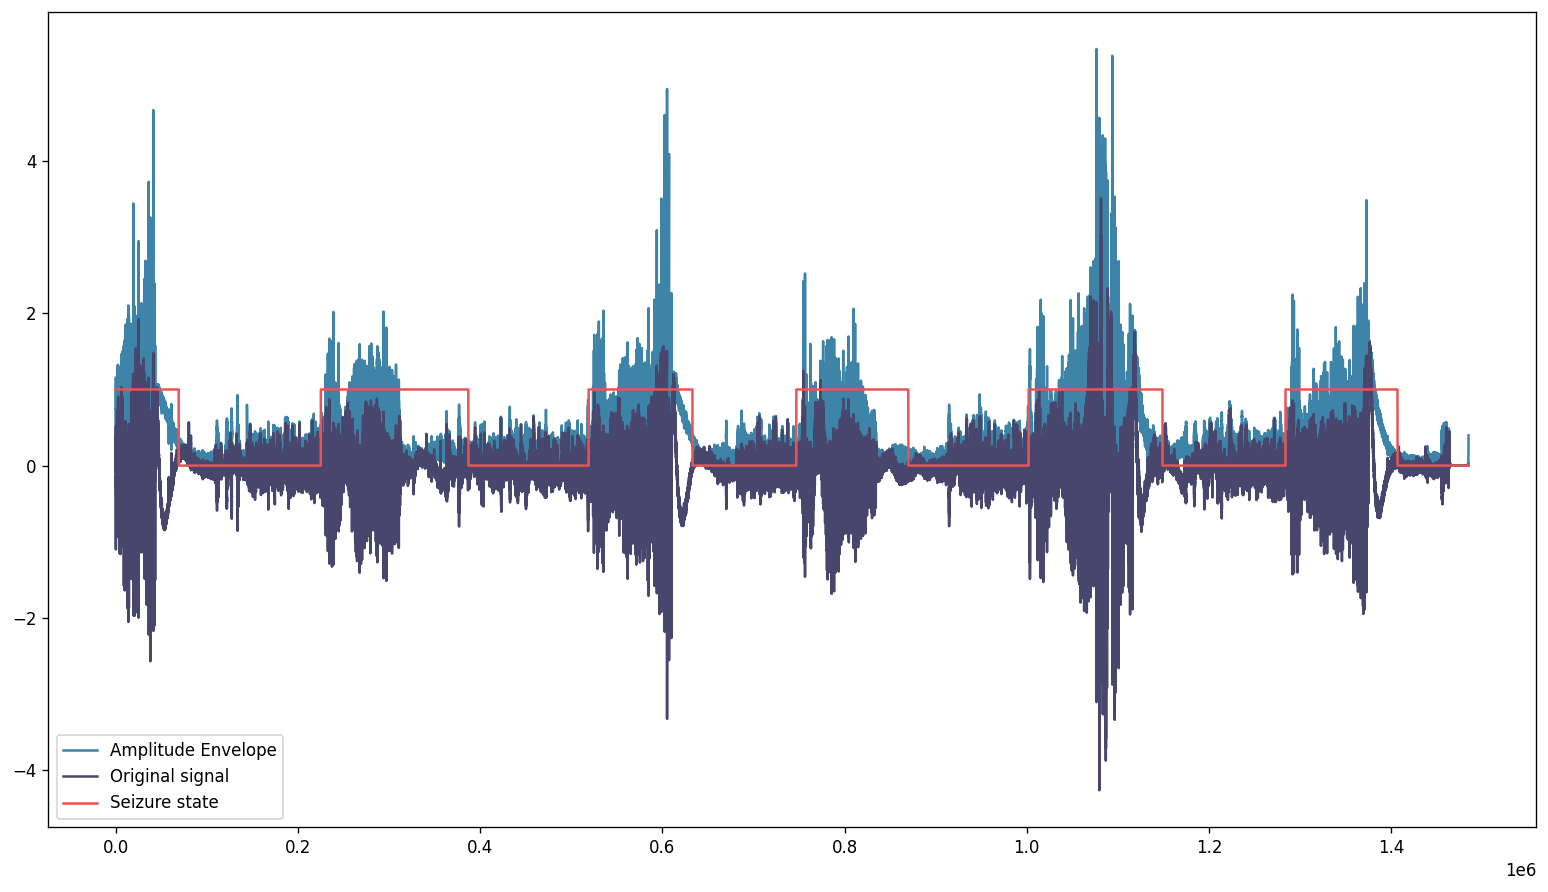

In [35]:
from scipy.signal import hilbert

data = raw_data
signal = data[:, 1]
analytic_signal = hilbert(signal)
amplitude_envelope = np.abs(analytic_signal)

fig = plt.figure(figsize=(16, 9), dpi=120)
plt.plot(amplitude_envelope, c='#3D84A8', label='Amplitude Envelope')
plt.plot(signal, c='#48466D', label='Original signal')
plt.plot(labels, c='#EA5455', label="Seizure state")
plt.legend(loc="lower left")
plt.show()

In [36]:
def apply_hilbert_transform(data):
    '''
    Computes the hilbert transform for each signal in the data
    Extracts and returns the amplitude envelope for each channel
    '''
    for channel in range(features):
        analytic_signal = hilbert(data[:, channel])
        data[:, channel] = np.abs(analytic_signal)
        
    return data

In [37]:
# applying the hilbert transform on each channel in the dataset
data = raw_data
data = fs.transform(data)
data = apply_hilbert_transform(data)

In [38]:
# splitting the transformed dataset into training, validation and test sets
X, Y = train_val_test_split(data, labels)
x_train, x_val, x_test = X
y_train, y_val, y_test = Y

In [39]:
# generate data sequences for classification
x_train_seq = generate_data_sequence(x_train, sequence_length, step)
x_val_seq = generate_data_sequence(x_val, sequence_length, step)
x_test_seq = generate_data_sequence(x_test, sequence_length, step)
print(x_train_seq.shape)
print(x_val_seq.shape)
print(x_test_seq.shape)

(1189485, 1, 8)
(147015, 1, 8)
(148500, 1, 8)


In [43]:
perform_classification(x_train_seq, y_train, x_val_seq, y_val, x_test_seq, y_test)

Run #1
Training model...Done
Evaluating model...Done
Test Accuracy: 75.5%
--------------------------------------------------
Run #2
Training model...Done
Evaluating model...Done
Test Accuracy: 73.19%
--------------------------------------------------
Run #3
Training model...Done
Evaluating model...Done
Test Accuracy: 79.95%
--------------------------------------------------
Run #4
Training model...Done
Evaluating model...Done
Test Accuracy: 66.31%
--------------------------------------------------
Run #5
Training model...Done
Evaluating model...Done
Test Accuracy: 68.01%
AVERAGE ACCURACY: 72.59%
